In [2]:
%run lgs00_general_functions.ipynb

In [3]:
%run lgs01_functions_for_getting_aa_pseudopositions.ipynb

In [4]:
def make_interleaved_fasta_sequential(fasta_path_in, fasta_path_out):
    with open(fasta_path_in, 'r') as fin:
        lines = fin.readlines()
        
    with open(fasta_path_out, 'w') as fout:
        header = ''
        seq = ''
        for i in range(len(lines)):
            if i==0:
                fout.write('>' + lines[i][1:-1] + '\n')
            else:
                if lines[i][0] =='>':
                    fout.write('\n' + '>' + lines[i][1:-1] + '\n')
                else:
                    fout.write(lines[i][:-1])

In [5]:
gfps_all = pd.read_csv(os.path.join(data_folder, 'alignments','extant_fluorescent_proteins_data.csv'))
natural_mask = gfps_all['derived_from']=='nature'
green_mask = gfps_all['color']=='green'

In [6]:
wts = {}
for x in  gfps_all[natural_mask].index:
    wts[gfps_all.loc[x]['name']] = gfps_all.loc[x]['aa_seq']

In [7]:
alignment = {}
with open(os.path.join(data_folder, 'alignments',
                               'extant_fluorescent_proteins_TCoffee_aligned.fasta'), 'r') as f:
    lines = f.readlines()
for i in range(0, len(lines), 2):
    alignment[lines[i][1:lines[i].index('|')]] = lines[i+1].strip()


In [8]:
def get_seq_identity(s1, s2, gapper='-'):
    identity = sum(1 for a,b in zip(s1,s2) if a==b!=gapper)
    length = sum(1 for a,b in zip(s1,s2) if a!=gapper and b!=gapper)
#     length=len(s1)
    return 100.*identity/length

In [9]:
pairwise = {}
skip = []
for s1 in list(alignment.keys()):
    for s2 in list(alignment.keys()):
        skip.append(s1+s2)
        if s1!=s2 and (s2+s1) not in skip:
            identity = get_seq_identity(alignment[s1],alignment[s2])
            pairwise[frozenset([s1,s2])] = identity
#             if identity>95:
#                 print(identity,s1,s2)

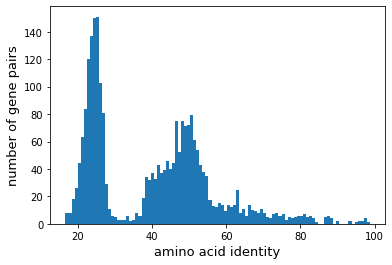

In [10]:
# plt.hist(pairwise.values(), bins=100)
# label_plot_axis(x='amino acid identity', y='number of gene pairs');

# New alignment quasipositions

Let 'quasipositions' be the positions of aminoacids in the big alignment of >70 wt GFPs. 
Get dictionary linking the quasipositions to the native position of each gene: **{quasipos1: {gene1: nativepos_gene1, gene2: nativepos_gene2, ...}, quasipos2: ...}**

In [21]:
quasilength = len(alignment['avGFP'])

In [12]:
quasipos_to_nativepos = {} 

for i in range(quasilength):
    quasipos_to_nativepos[i] = {}
    for gene in alignment.keys():
        wt2pseudo = get_pseudo_aa_positions(wts[gene], alignment[gene])
        try:
            quasipos_to_nativepos[i][gene] = list(wt2pseudo.keys())[list(wt2pseudo.values()).index(i)]
        except:
            quasipos_to_nativepos[i][gene] = np.nan

In [13]:
quasipos_to_nativeaa = {x: {gene: alignment[gene][x] for gene in alignment.keys()} for x in range(quasilength)}

In [14]:
max_len = max([len(x) for x in wts.values()])
nativepos_to_quasipos = {}

for i in range(max_len):
    nativepos_to_quasipos[i] = {}
    for gene in alignment.keys():
        wt2pseudo = get_pseudo_aa_positions(wts[gene], alignment[gene])
        try:
            nativepos_to_quasipos[i][gene] = list(wt2pseudo.values())[list(wt2pseudo.keys()).index(i)]
        except:
            nativepos_to_quasipos[i][gene] = np.nan

In [15]:
quasipos_aa_occupancy = {}
quasipos_aa_states = {}
for i in range(quasilength):
    extant = [alignment[gene][i] for gene in alignment]
    quasipos_aa_occupancy[i] = ''.join(set(extant))
    quasipos_aa_states[i] = extant

# Functions

In [16]:
namekey = {'amac':'GFPxm', 'av':'avGFP', 'cgre':'cgreGFP', 'pplu':'ppluGFP2'}

In [17]:
def check_n_mut_extant(list_of_muts):
    if list_of_muts=='wt' or type(list_of_muts)!=str:
        return np.nan
    else:
        muts = list_of_muts.split(':')
        extant = 0
        for mut in muts:
            try:
                if mut[-1] in quasipos_aa_occupancy[int(mut[:-1])]:
                    extant += 1
            except:
                print(list_of_muts)
        return extant

In [18]:
def check_if_mutations_cooccur(genotype, alignment):
    muts = genotype.split(':')
    wt = []
    cooccur = False
    for gene in alignment.keys():
        current = True
        for m in muts:
            if alignment[gene][int(m[:-1])] != m[-1]:
                current = False
                break
        if current==True:
            cooccur = True
            wt.append(gene)
#     if len(wt)>0:
#         print(muts, wt)
    return wt

In [19]:
def get_neutral_and_deleterious_states(singles_effects_dict, gene, input_pos='pseudo', output_pos='pseudo', 
                                       threshold=0.25):
    namekey = {'amac':'GFPxm', 'av':'avGFP', 'cgre':'cgreGFP', 'pplu':'ppluGFP2'}
    ok = []
    bad = []
    for mut in singles_effects_dict:
        
        if mut=='wt':
            pass
        else:
            if singles_effects_dict[mut] < threshold:
                is_bad = True
            else:
                is_bad = False
            
            if input_pos==output_pos:
                pass
            elif input_pos=='pseudo' and output_pos=='native':
                mut = mut[0] + pseudopos_to_nativepos[int(mut[1:-1])][genekey[gene]] + mut[-1]
            elif input_pos=='pseudo' and output_pos=='quasi':
                natpos = pseudopos_to_nativepos[int(mut[1:-1])][genekey[gene]]
                quasipos = nativepos_to_quasipos[natpos][namekey[gene]]
                mut = mut[0] + str(quasipos) + mut[-1]
                
            ok.append(mut[1:-1] + mut[0])
            if is_bad == True:
                bad.append(mut[1:-1] + mut[-1])
            else:
                ok.append(mut[1:-1] + mut[-1])
    return set(ok), set(bad)    

In [20]:
def get_wt_states(name, wts=wts):
    ok = []
    for i in range(len(wts[name])):
        ok.append(str(nativepos_to_quasipos[i][name]) + wts[name][i])
    return set(ok)